## Pool of high density
Frames and movie

In [35]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.animation as animation
import matplotlib.gridspec as gspec
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [36]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [37]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/gridGlob.nc'

grid_fileNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/ptracersGlob.nc'
RhoRef = 999.79998779 

In [38]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]
    
hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfac = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfac)

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]

In [39]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 4D arrays 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T) + beta*(S))
    return rho

def call_rho(tslice,state,zslice,yslice,xslice):
    T = state.Temp.isel(T=tslice,Z=zslice,X=xslice,Y=yslice)
    S = state.S.isel(T=tslice,Z=zslice,X=xslice,Y=yslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

In [40]:
# Cross-shelf velocity, Plot1
def Plot1(gs_ax,t,Tr,xx,zz,textt, Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr: tracer concentration sliced in x-z (nt,nz,nx)
       t: time index.
       xx: x coords, sliced
       yy: y coords, sliced
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    mesh = ax.contourf(xx/1000,zz,Tr,
                       csU,cmap=cmap_name)
    ax.contour(xx/1000,zz,Tr,[19,dens_sb-1000], colors='k')
    ax.set_facecolor((180/255.0, 175/255.0, 175/255.0))
    ax.text(0.1,-0.3,'%s at day %1.1f'%(textt, t/2.),fontsize=16,transform=ax.transAxes)
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.tick_params(axis='y', pad=1)
    
def Plot2(gs_ax,t,Tr,yy,zz,Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in y-z (nt,nz,ny)
       tslice: advective phase slice to average over.
       xind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    mesh = ax.contourf(yy/1000,zz,Tr,
                       csU,
                       cmap=cmap_name)
    cont = ax.contour(yy/1000,zz,Tr,[dens_sb-1000], 
                      colors='k')
    
    if tt == 0:
        cbar_ax = ff.add_axes([0.91, 0.62, 0.016, 0.26])
        cb = plt.colorbar(mesh, cax=cbar_ax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f')
        cb.ax.yaxis.set_tick_params(pad=1)

        ax.set_facecolor((180/255.0, 175/255.0, 175/255.0))
    
    ax.set_facecolor((205/255.0, 201/255.0, 201/255.0))
    #ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.set_xlabel('Cross-shelf distance (km)',labelpad=0.3)
    ax.tick_params(axis='y', pad=1)
    
def Plot3(ff,gs_ax,t,ConcFilt,xx,yy,xind,yind,depth,Trmin=0,Trmax=2):
    
    ax = plt.subplot(gs_ax)
    
    mesh = ax.contourf(xx/1000,yy/1000,ConcFilt,
                       21, 
                      vmax=Trmax, 
                      vmin=Trmin,
                      cmap=cmap_name2)
    
    ax.set_facecolor((180/255.0, 175/255.0, 175/255.0))
    cont = ax.contour(xx/1000,yy/1000,ConcFilt,[dens_sb-1000], 
                      colors='k')
    
    ax.text(0.02,0.9,'Shelf bottom',transform=ax.transAxes,color='w')
    SB = ax.contour(xx/1000,yy/1000,
                    depth,
                    [50,75,100,125,150,200,250,300,350,400,450,500],
                    colors=['0.5','0.5','0.5','0.5','0.1','0.5','0.5','0.5','0.5','0.5','0.5','0.5'],
                    linewidths=[0.75] )
    
    ax.axhline(Y[yind]/1000, color='0.3', linestyle='--')
    ax.axvline(X[xind]/1000, color='0.3', linestyle='--')
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    ax.set_xlabel('Alongshelf distance (km)',labelpad=0.3)
    ax.set_ylabel('Cross-shelf distance (km)',labelpad=0.3)

In [41]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def ConcAreaFunc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*(nz-1) - BottomInd) # Get index of unreversed z axis
  
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf))


In [42]:
def next_frame(time,ff,state, Trmin=78, Trmax=300,textt = 'Oxygen concentration ($\mu mol/kg$)'):
    
    tt = starttime + time 
        
    dens1 = call_rho(tt,state,zslice,yind,xslice)
    tr_plot1 = np.ma.masked_array(dens1, maskC[zslice, yind, xslice])
    
    dens2 = call_rho(tt,state,zslice_2,yslice,xind)
    tr_plot2 = np.ma.masked_array(dens2, maskC[zslice_2,yslice, xind])
    
    dens3 = call_rho(tt,state,slice(0,104),slice(0,360),slice(0,616))
    concFilt = ConcAreaFunc(dens3,hFacC,rA,Depth,104,sbdepth=-152.5)
    
    gs0 = gspec.GridSpec(2, 1, height_ratios=[0.5,1], hspace=0)
    gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.12)
    

    Plot1(gs01[0],tt,tr_plot1-1000,X[xslice],Z[zslice],textt, Trmin=Trmin, Trmax=Trmax)
    Plot2(gs01[1],tt,tr_plot2-1000,Y[yslice],Z[zslice_2], Trmin=Trmin, Trmax=Trmax)
    Plot3(ff,gs0[1],tt,concFilt[yslice_bac,xslice_bac]-1000,X[xslice_bac],Y[yslice_bac],
          xind,yind,Depth[yslice_bac,xslice_bac],
          Trmin=Trmin,Trmax=Trmax)
   
    #plt.tight_layout()



In [43]:
dens_profile = call_rho(0,state,slice(0,104),50,180)
dens_sb = dens_profile[30].data  
print(dens_sb)

1023.2520813923421


/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


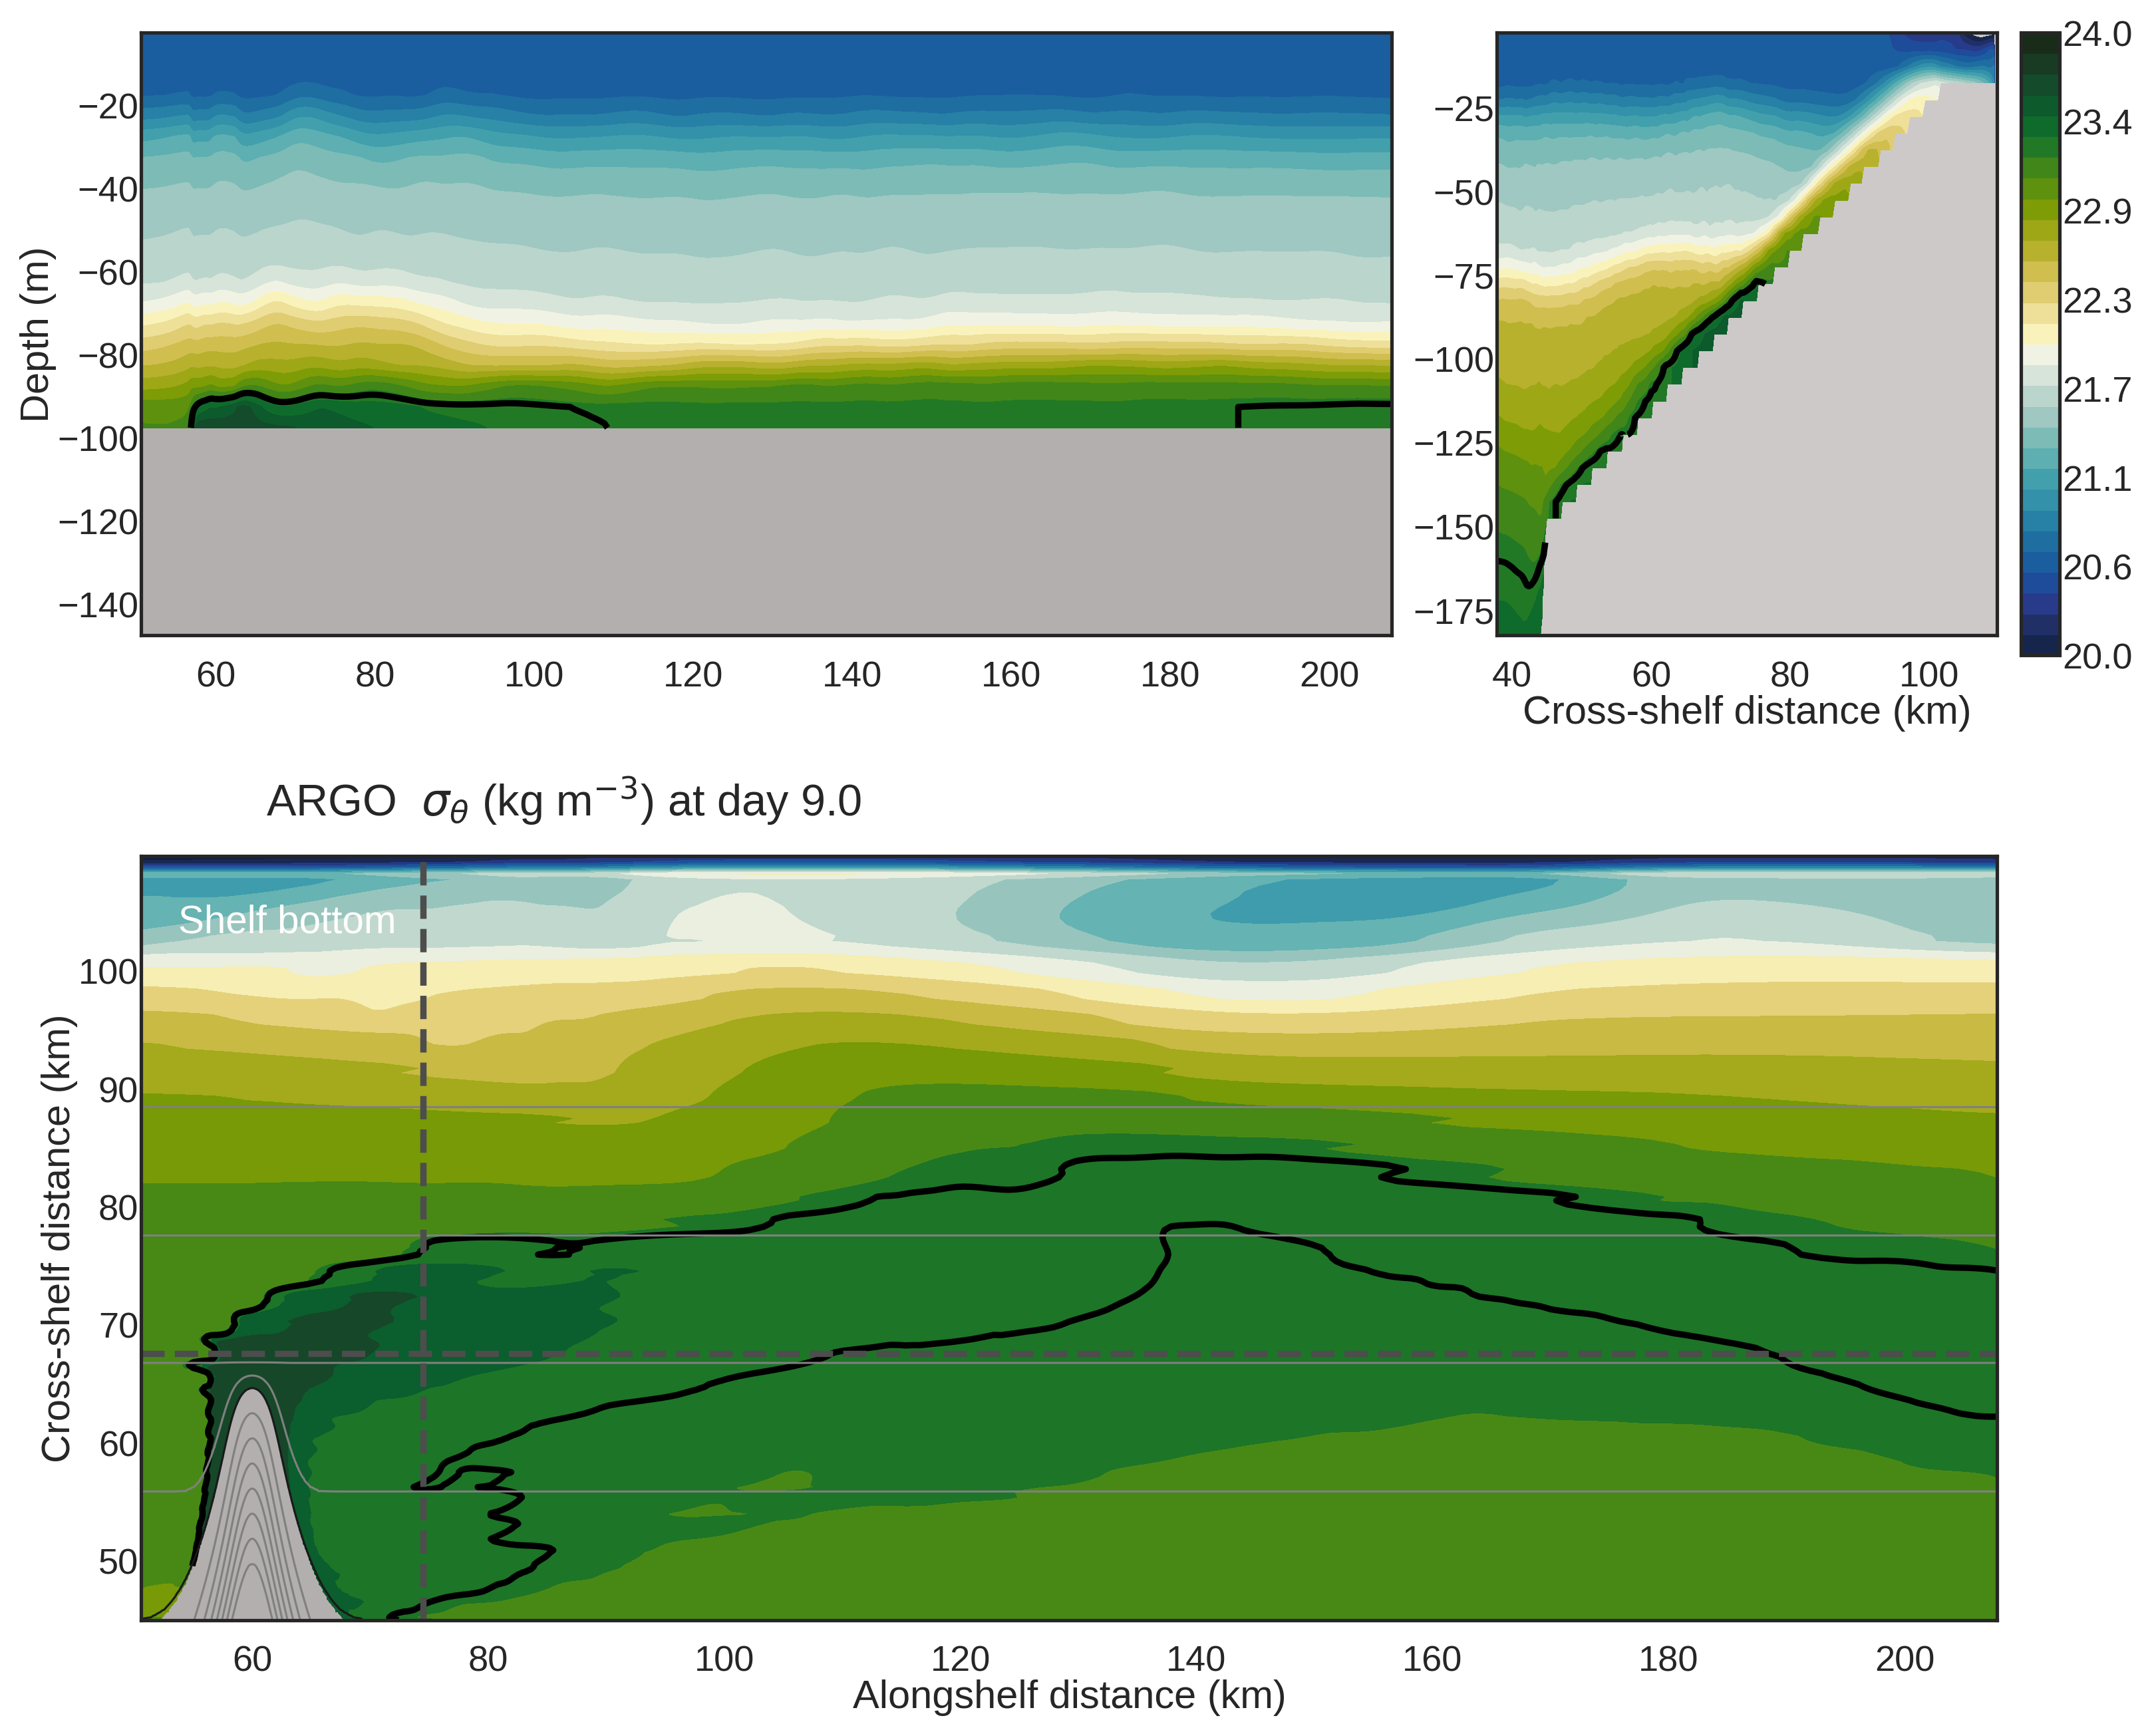

In [44]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 260
yind = 241 # y index for alongshore cross-section
zind = 38

zslice = slice(0,30)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

cmap_name = cmo.cm.delta
cmap_name2 = cmo.cm.delta
sns.set_context('talk')
sns.set_style('white')

title_text = r'ARGO  $\sigma_{\theta}$ (kg m$^{-3}$)'
plt.rcParams['font.size'] = 14.0

starttime = 0

ff = plt.figure(figsize=(12,12),dpi=dpi)
   
for tt in range(19):
    
    next_frame(tt,ff,state, textt=title_text, Trmin=1020-1000, Trmax=1024-1000)
    frame_name2 = ('frames/dens_ARGO_tt%02d.png' %tt) 
    plt.savefig(frame_name2,  format='png', bbox_inches='tight')



### Animation

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


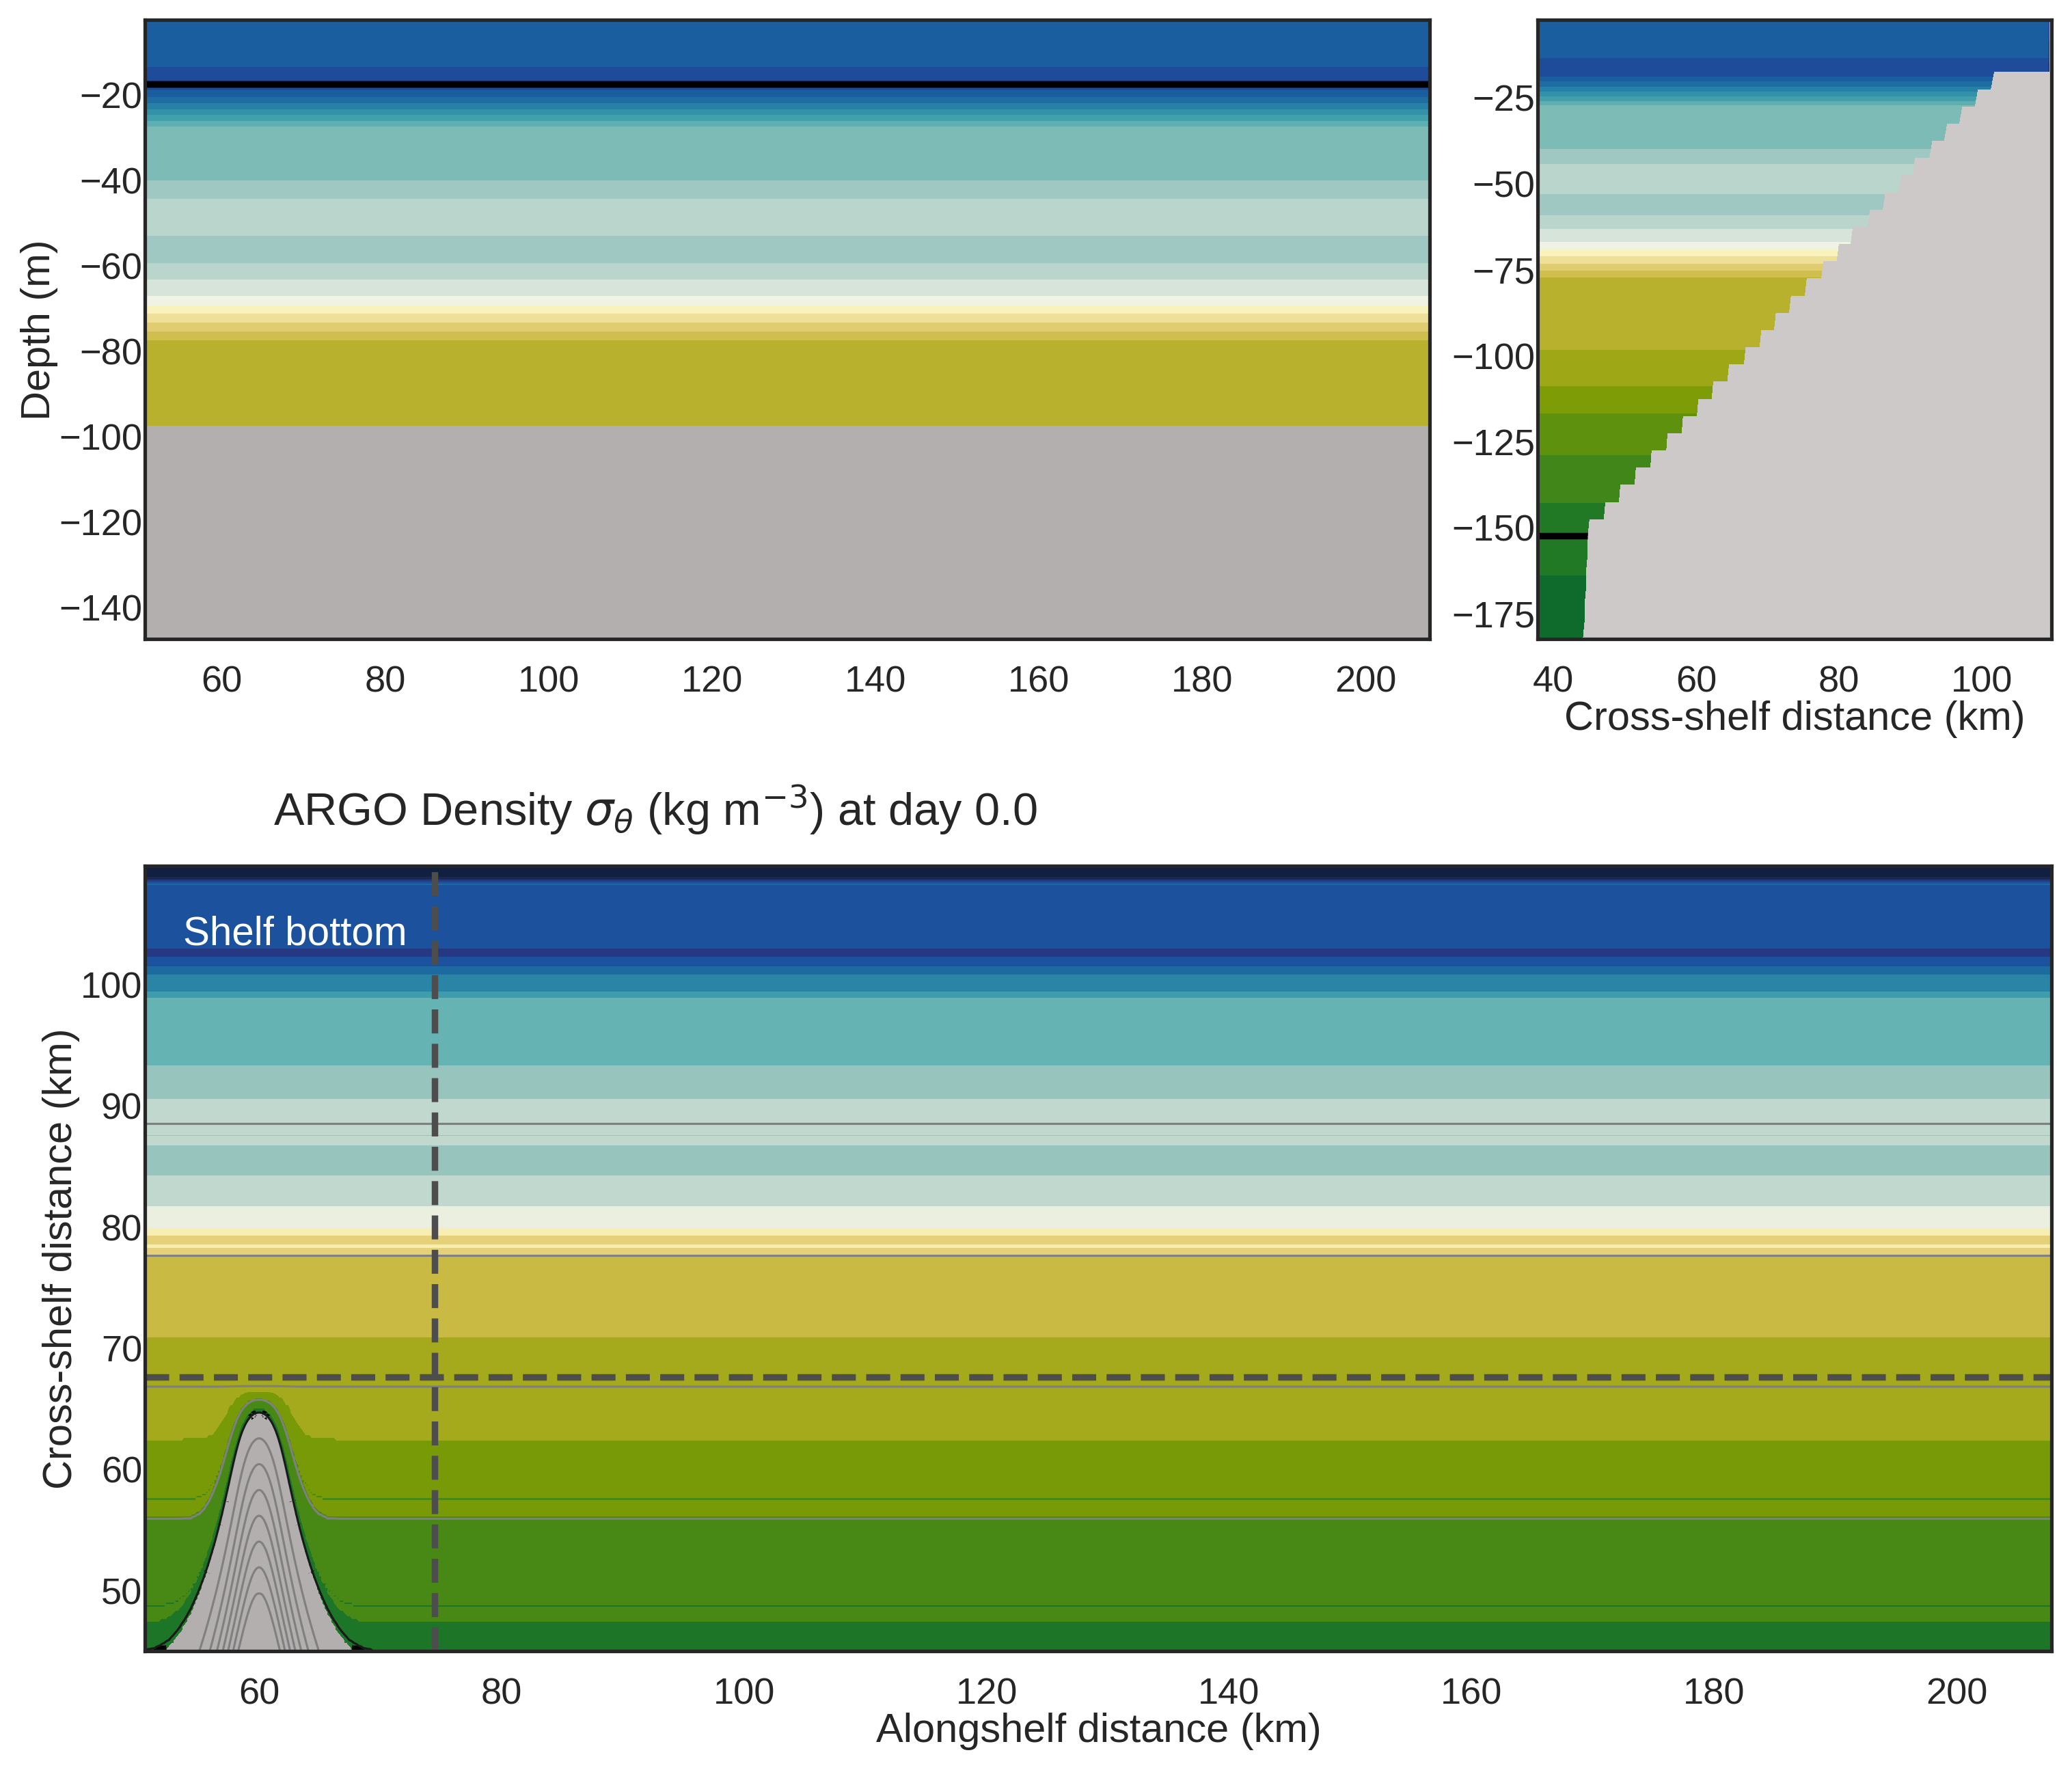

In [45]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 260
yind = 241 # y index for alongshore cross-section
zind = 38

zslice = slice(0,30)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

cmap_name = cmo.cm.delta
cmap_name2 = cmo.cm.delta
sns.set_context('talk')
sns.set_style('white')

title_text = r'ARGO Density $\sigma_{\theta}$ (kg m$^{-3}$)'
plt.rcParams['font.size'] = 14.0

starttime = 0

ff = plt.figure(figsize=(12,12),dpi=dpi)

def init():
    next_frame(0,ff, state, textt=title_text, Trmin=1020-1000, Trmax=1024-1000)
def animate(t):
    next_frame(t,ff, state, textt=title_text, Trmin=1020-1000, Trmax=1024-1000)

    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.FuncAnimation(ff, animate, init_func=init,frames=19,repeat=False)
anim.save('density_ARGO.mp4', writer=writer)